In [1]:
# From https://github.com/ejbosia/Fermat-Spirals


# these are the Classes used from the Shapely library
# - https://shapely.readthedocs.io/en/stable/manual.html
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import LineString
from shapely.geometry import LinearRing

# these are the different cap styles for the "buffer" function
from shapely.geometry import CAP_STYLE, JOIN_STYLE

# plotting
import matplotlib.pyplot as plt

# arrays and math
import numpy as np

# image processing
import cv2

# opening files and paths
import os

In [2]:
'''
Convert an input binary image into a formatted list of contours with heirarch information
 - this returns all of the contours and heirarchy information
 - returns a list of tuples --> (list of points, heirarchy)
'''
def generate_border_lines(image, approximation = cv2.CHAIN_APPROX_SIMPLE):

    # cv2.RETR_CCOMP outputs parent-children relationships in the heirarchy
    contours,heirarchy = cv2.findContours(image, cv2.RETR_CCOMP, approximation)  

    contour_list = []

    for contour,heirarchy in zip(contours, heirarchy[0]):
        point_list = []
        for point in contour:
            point_list.append(tuple(point[0]))
            
        contour_list.append((point_list, heirarchy))

    return contour_list

In [3]:
'''
Get all of the children of the parent contour using heirarchy information
'''
def get_children(contour_list, parent_contour):

    child_list = []

    first_child_index = parent_contour[1][2]
    child = contour_list[first_child_index]
    child_list.append(child[0])


    # loop while there are more children
    while not child[1][0] == -1:
        next_child_index = child[1][0]
        child = contour_list[next_child_index]
        child_list.append(child[0])
    
    # return the list of children
    return child_list

In [4]:
'''
Convert formatted list of contours with heirarchy info into polygons
 - a shapely polygon has an exterior list of points, and a list of interiors (lists of points)
 - this uses the heirarchy info to find the interiors of an exterior polygon
'''
def create_contour_families(contour_list):

    family_list = []

    # find the first parent contour
    for contour in contour_list:
        
        # start with a parent contour
        if contour[1][3]==-1:

            # if there are no children, create an empty family with only the parent contour
            if contour[1][2] == -1:
                child_list = []
            # otherwise, find all of the children
            else:
                child_list = get_children(contour_list, contour)

            if len(contour[0]) > 2:
                family_list.append(Polygon(contour[0], holes=child_list))

    return family_list

In [5]:
'''
Recursively run the distance transform on the input polygon
- if result is empty, terminate with empty list
- if result is Polygon, add current Polygon
- if result is MultiPolygon, run for each Polygon in the MultiPolygon
'''
def distance_transform(polygon, distance):
        
    t = polygon.buffer(distance, cap_style = CAP_STYLE.flat, join_style = JOIN_STYLE.mitre)
    
    # if t is empty, return the empty list
    if not t:
        return []
        
    result = []

    # MultiPolygons are the result of concave shapes ~ distance transform creates multiple polygons
    if t.type == "MultiPolygon":
        for p in t:
            result.append([p])
            result[-1].extend(distance_transform(p, distance))
    else:
        result.append(t)
        result.extend(distance_transform(t, distance))
        
    return result


'''
Plot all of the contours of an input polygon
'''
def plot_poly(polygon):
    plt.plot(*polygon.exterior.xy)
    
    for i in polygon.interiors:
        plt.plot(*i.xy)


'''
Plot all of the contours in the result of a distance transform
'''
def plot_contours(result):
    for p in result:
        if type(p) is list:
            plot_contours(p)
        else:
            plot_poly(p)

In [6]:
'''
Cut a linestring at a specified distance. This always returns at least one linestring and a None, or two linestrings
'''
def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0:
        return [None, LineString(line)]
    elif distance >= line.length:
        return [LineString(line), None]
    
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]
    # this is between the last point
    # this is to catch for linear rings (last point projection is 0)
    cp = line.interpolate(distance)
    return [
        LineString(coords[:-1] + [(cp.x, cp.y)]),
        LineString([(cp.x, cp.y)] + [coords[-1]])]

'''
Reformat the linestring so position 0 is the start point. This may involve inserting a new point into the contour.
'''
def cycle(contour, point):
    
    # find the point projection on the contour
    proj = contour.project(point)
    
    # cut the contour at the projection distance
    result = cut(contour, proj)
    
    if result[0] is None:
        points = result[1]
    elif result[1] is None:
        points = result[0]
    else:
        [ls1,ls2] = result
        points = list(ls2.coords) + list(ls1.coords)

    return LineString(points)

In [7]:
'''
Plot a single path
'''
def plot_path(path, color=None):
    
    X = []
    Y = []

    for p in path:
        X.append(p[0])
        Y.append(p[1])
        
    plt.plot(X,Y,c=color)


'''
Plot a list of paths
'''
def plot_recursive_path(total_path, color=None):
    
    rest = []
    
    for path in total_path:
        if type(path) is list:
            plot_path(path, color)
        else:
            rest.append(path)
            
    plot_path(rest, color)

In [8]:
'''
Generate a spiral path from an input family of contours
'''
def spiral_path(contour_family, distance):

    points = []

    if not contour_family:
        return points
    
    # set the start contour
    contour = contour_family[0].exterior
    
    # set the starting point as p0 (arbitrary)
    start = Point(contour.coords[0])
    
    # calculate the end point a distance away from the end of the contour
    end = calculate_point(contour, contour.length, distance, forward=False)
    
    # if the end point was not found, return an empty list ~ contour is too small
    if end is None:
        return []
    
    # add the points before the reroute point to the path
    ls, _ = cut(contour, contour.project(end))                
    points.extend(ls.coords)
    
    # the previous contour is used to force the point away from acute angles
    previous = contour
    
    # loop through each "inner" contour
    for polygon in contour_family[1:]:
        
        contour = polygon.exterior
        
        # get the next start point
        start = contour.interpolate(contour.project(end))
                
        # cycle so the start point is the coordinate at index 0
        contour = cycle(contour, start)
                
        # calculate the end point a distance away from the previous contour
        end = calculate_point_contour(contour, previous, distance)
                
        if end is None:
            break

        # add the points before the reroute point to the path
        ls, _ = cut(contour, contour.project(end))                
        points.extend(ls.coords)
        
        # set the previous to the processed contour so the next spiral generation can measure the distance from this
        previous = contour
        
    return points

In [9]:
'''
Find the next endpoint in the path
 - this is the endpoint one "loop" around the contour
 - the next endpoint should be where the projection distance is greater than the distance away from the start
'''
def calculate_break(path, start, distance):

    dis = 0
    
    while dis <= distance:
        _,path = cut(path,distance)
        
        if path is None:
            return None
        
        dis = path.project(start)
    
    return path.interpolate(dis)

In [10]:
'''
Build the outer spiral of the fermat spiral
'''  
def outer_spiral(path, distance):
    path = LineString(path)
    
    # start at the first point in the contour
    start = Point(path.coords[0])
    
    spiral = []
    outer_pieces = []

    while True:
        # find the "end" point of the contour, which is the point that is projected once around the contour
        end = calculate_break(path, start, distance)

        # return if the end point is the end of the path
        if end is None or path.project(end) == path.length:        
            return spiral+list(path.coords), outer_pieces, True
        
        # get the reroute point away from the end towards start
        reroute = calculate_point(path, path.project(end), distance, forward=False)
        # plt.scatter(reroute.x,reroute.y,c='orange')
        
        # cut the path at the reroute point
        p1,center = cut(path, path.project(reroute))

        # complete the reroute of the path at the end point
        center,p2 = cut(center, center.project(end))

        # get the inner point
        # - this is the point that is a distance farther than the projection distance
        start = calculate_break(p2, reroute, distance)

        # add these coordinates to the spirals
        spiral.extend(list(p1.coords))

        # if the length of the remaining path is where the next jump would be, break the loop
        if start is None or p2.project(start) == p2.length:    
            # outer_pieces.append(p2)
            return spiral + list(p2.coords)[::-1], outer_pieces, True
        
        # cut the inner contour at this point
        outer, inner = cut(p2, p2.project(start))
        outer_pieces.append(outer)

        # set the path to the inner part of the spiral
        path = inner
        


In [11]:
'''
Build the inner spiral of the fermat spiral using the pieces of the spiral
'''
def inner_spiral(outer_pieces, distance, center, path):    
    spiral = []
    
    if len(outer_pieces) == 0:
        pass
    else:
        
        # reverse the outer pieces to go from inside to outside
        outer_pieces = outer_pieces[::-1]
        contour = outer_pieces[0]
        formatted_pieces = []
        
        # adjust the center position dependent on the type of center (center in or center out)
        if center:
            
            contour = outer_pieces[0]
            contour, _ = cut(contour, contour.project(Point(path[-1])))
            formatted_pieces.append(contour)
        else:
            # find the point away from the endpoint of the current piece
            reroute = calculate_point(contour, contour.length, distance, forward=False)
            
            # remove the points after the reroute on the next contour
            contour, _ = cut(contour, contour.project(Point(path[-1])))
            formatted_pieces.append(contour)
            
            ls = LineString(path)
            ls, _ = cut(ls, ls.project(Point(contour.coords[-1])))
            
            path = list(ls.coords)
            
        
        for contour in outer_pieces[1:]:
            
            # find the point away from the endpoint of the current piece
            reroute = calculate_point(contour, contour.length, distance, forward=False)
            # remove the points after the reroute on the next contour
            contour, _ = cut(contour, contour.project(reroute))
            
            formatted_pieces.append(contour)
            
            
        # loop through the formatted pieces
        for i in range(len(formatted_pieces)-1):
            
            # collect the current and next piece
            c0 = formatted_pieces[i]
            c1 = formatted_pieces[i+1]
            
            # project the end of the formatted end piece of the next contour on the inner contour
            dis = c0.project(Point(c1.coords[-1]))
            
            # if the projection is the start point, do not cut
            if dis == 0:
                spiral.extend(list(c0.coords)[::-1])
            else:
                _, inner = cut(c0,  dis)
                spiral.extend(list(c0.coords)[::-1])
                
        
        # add the last piece
        spiral.extend(list(formatted_pieces[-1].coords)[::-1])
    
    return path + spiral

In [12]:
def convert_fermat(path,distance, debug=False):
    
    if path is None or not path:
        return []
    
    path, pieces, center = outer_spiral(path, distance)
    
    return inner_spiral(pieces, distance, center, path)
    

In [13]:
# create a spiral path
def fermat_path(contours, distance,debug=False):
    
    path = spiral_path(contours, distance)
    
    if path:
        fermat = convert_fermat(path, distance,debug)
    else:
        fermat = path
    
    return fermat

In [14]:
# calculate a point a distance away from a position on the contour in a given direction
# this is where the contour is rerouted to the next spiral
# - contour: LineString input
# - position: starting position to measure from
# - radius: distance away from the starting point
# - forward: direction along the contour to find the point
def calculate_point(contour, position, radius, forward = True):
    
    # set the direction of the error
    direction = 1 if forward else -1
    
    # set the starting guess based on the direction
    error = direction * radius
    
    distance = position
    
    # save the start point for distance calculations
    start = contour.interpolate(position)
    
    # loop while the error is out of bounds 
    while abs(error) > 0.000001:
        
        distance += error
        
        # return None if the endpoints of the contour are reached
        if distance >= contour.length or distance <= 0:
            return None
        
        # get point
        point = contour.interpolate(distance)
        
        # calculate distance
        new_dis = point.distance(start)
        
        # calculate error
        error = direction * (radius - new_dis)/2
        
    return point


# calculate a point a distance away from a position on the contour in a given direction
# this is where the contour is rerouted to the next spiral
# - contour: LineString input
# - position: starting position to measure from
# - radius: distance away from the starting point
# - forward: direction along the contour to find the point
def calculate_point_contour(contour, previous, radius):

    
    # pick the ending point
    point = calculate_point(contour, contour.length , radius, forward = False)
    
    if point is None:
        return point
    
    # cut the path at the midpoint
    temp, _ = cut(contour, contour.length/2)
    
    # if the distance from the point to contour is the radius, return the point
    if radius - point.distance(temp) < 0.000001:
        return point
    
    # else find a valid distance and binary search to find valid point
    distance = contour.project(point)
    
    while point.distance(temp) < radius:
        
        distance -= radius
        
        if distance < 0:
            return None
        
        point = contour.interpolate(distance)

        
    max_error = contour.length - distance
    
    error = max_error/2
    
    position = distance + error
    
    point = contour.interpolate(position)
    
    
    # binary search the distance ~ uses some arbitrary amount of iteration? ~ set to 10 rn
    for i in range(10):
        
        error = error/2
        
        if point.distance(temp) < radius:
            position -= error
        else:
            position += error
            
        point = contour.interpolate(position)
        
    return point

In [15]:
# this creates a fermat path recursively from a tree of Polygon objects
def generate_fermat_path(result, distance):
    
    branches = []

    contour_family = []

    # loop through each node or branch in the tree
    for node in result:
        
        # if the result node is a branch, recursively call this function on it
        if type(node) is list:
            branches.append(generate_fermat_path(node, distance))
        # if the result node is not a branch, add it to the contour family
        else:
            contour_family.append(node)

    # generate the fermat spiral from the root and the branches
    root = fermat_path(contour_family, distance,debug=False)

    # combine the root and the branches
    if root:
        return combine_paths(root, branches, distance)
    
    # if there is no root (not sure how this happens but it does) - just return the branches?
    else:
        return branches

In [16]:
# this generates the total path without combining the paths
def generate_total_path(result, distance):
    
    total_path = []
    contour_family = []
    
    # loop through each value in the result
    for branch in result:
        if type(branch) is list:  
            total_path.extend(generate_total_path(branch, distance))
        else:
            contour_family.append(branch)

    results = spiral_path(contour_family, distance)

    total_path.append(results)

    return total_path

In [17]:
# this generates the total path without combining the paths
def generate_total_pathf(result, distance):
    
    total_path = []
    contour_family = []
    
    # loop through each value in the result
    for branch in result:
        if type(branch) is list:  
            total_path.extend(generate_total_pathf(branch, distance))
        else:
            contour_family.append(branch)

    results = convert_fermat(spiral_path(contour_family, distance),distance)

    total_path.append(results)

    return total_path

In [18]:
# execute runs the path function "fnc" on an image
# - use this to generate the path from an image
def execute(image, distance ,fnc):
    
    total_path = []
    
    # create the polygons from the image
    contours = generate_border_lines(image, approximation=cv2.CHAIN_APPROX_NONE)
    polygons = create_contour_families(contours)
        
    # each individual polygon should be a separate distinct polygon in the image
    for polygon in polygons:
        
        # simplify the polygon to remove excess points - this helps with processing
        polygon = polygon.simplify(distance/2)
        
        # generate the distance transform for the polygon
        result = distance_transform(polygon, -distance)
        
        # if there is a result, run the path generation function on the result
        if result:
            total_path.extend(fnc(result, distance))
    
    return total_path

In [19]:
'''
Connect root and branch fermat spirals
'''
def combine_paths(root, branches, dis):
        
    root_ls = LineString(root)
        
    # find the start and end points of the root
    for b in branches:

        if not b:
            continue
        
        start = b[0]
        end = b[-1]
        
        
        # project end onto the root
        end_cut_dis = root_ls.project(Point(end))
        
        point = root_ls.interpolate(end_cut_dis)

        int_buff = point.buffer(dis)

        # get the line within the buffer distance of the point
        possible_line = int_buff.intersection(root_ls)

        start_pt = None
        
        if possible_line.type == "LineString":
            start_pt = possible_line.interpolate(possible_line.project(Point(start)))
        else:
            for item in possible_line:
                if item.type == "LineString":
                    # need to use this check instead of intersects because intersects will return false for some reason
                    test = item.interpolate(item.project(point))
                    if test == point:
                        start_pt = item.interpolate(item.project(Point(start)))
                        break

                
        start_cut_dis = root_ls.project(start_pt)        
                
        if start_cut_dis == 0:
            _,l2 = cut(root_ls, end_cut_dis)
            new_list = [root_ls.coords[0]] + b + list(l2.coords)
        elif end_cut_dis == 0:
            _,l2 = cut(root_ls, start_cut_dis)
            new_list = [root_ls.coords[0]] + b[::-1] + list(l2.coords)
        
        elif start_cut_dis == root_ls.length:
            l1,_ = cut(root_ls, end_cut_dis)
            new_list = list(l1.coords) + b + [root_ls.coords[-1]]

        elif end_cut_dis == root_ls.length:
            l1,_ = cut(root_ls, start_cut_dis)
            new_list =  list(l1.coords) + b[::-1] + [root_ls.coords[-1]]       

        
        elif start_cut_dis < end_cut_dis:
            
            l1,_ = cut(root_ls, start_cut_dis)
            _,l2 = cut(root_ls, end_cut_dis)
            
            new_list = list(l1.coords) + b + list(l2.coords)
        else:
            
            l1,_ = cut(root_ls, end_cut_dis)
            _,l2 = cut(root_ls, start_cut_dis)
            
            new_list =  list(l1.coords) + b[::-1] + list(l2.coords)       
        
        root_ls = LineString(new_list)
        
    return list(root_ls.coords)

In [20]:
target_width = 38
target_height = 38
border = 1

image = np.ones((target_height + 2 * border, target_width + 2 * border))

for i in range(target_width + 2):
    for j in range(border):
        image[j,i] = 0
        image[target_height + 1 - j,i] = 0

for i in range(target_height + 2):
    for j in range(border):
        image[i,j] = 0
        image[i, target_width + 1 - j] = 0

image = (image * 255).astype(int)

cv2.imwrite('files/bb.png', image)
image = cv2.imread('files/bb.png', 0)

In [21]:
#filename = 'files/square.png'
# image should be in binary format
#image = cv2.imread(filename,0)
target = 240.667

def total_length(res):
    # generate the un-connected fermat spiral output
    results = np.array(res)
    length = 0
    for i in range(len(results[0])):
        length += np.linalg.norm(results[0][i] - results[0][i-1])
    return length

def total_length_opt(args):
    distance=args[0]
    # generate the un-connected fermat spiral output
    results = np.array(execute(image, distance, generate_total_pathf))
    length = 0
    for i in range(len(results[0])):
        length += np.linalg.norm(results[0][i] - results[0][i-1])
    return abs(length-target)

In [22]:
from scipy.optimize import minimize

x0=[1]
res = minimize(total_length_opt, np.array(x0), method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
optimized_distance = res.x[0]
print("optimized distance: ", optimized_distance)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 68
optimized distance:  4.236104166507728


240.667000007629


<IPython.core.display.Javascript object>


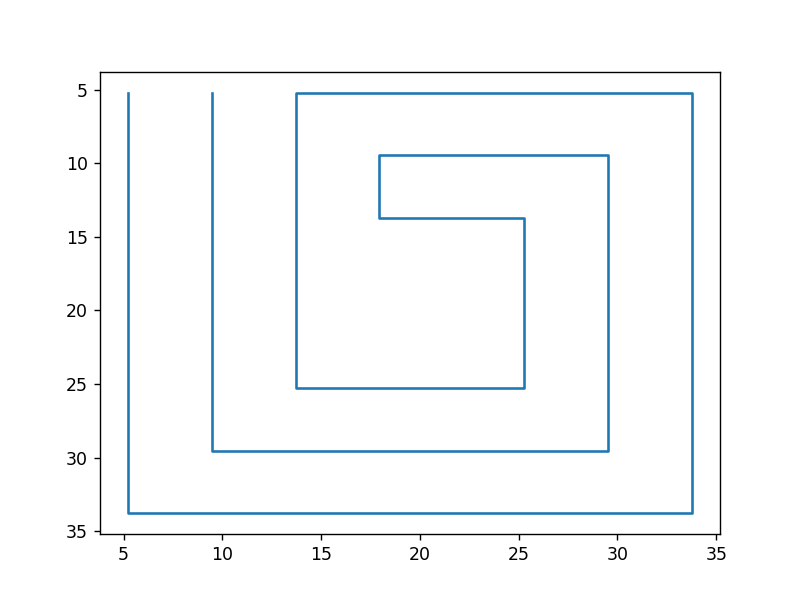

CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 40.3 ms


In [23]:
%%time
%matplotlib notebook

'''
This cell runs the complete pipeline from image to CFS output
'''

# distance in between each contour
distance = optimized_distance

# generate the un-connected fermat spiral output
results = execute(image, distance, generate_total_pathf)

print(total_length(results))

# plot and show the path
plot_recursive_path(results)
plt.gca().invert_yaxis()
plt.show()


In [24]:
from stl import mesh
import mapbox_earcut as earcut

def lineToSTL(pts, name, z = 19):
    pts_base = [ [ax,ay,0] for (ax,ay) in pts]
    pts_top = [ [ax,ay,z] for (ax,ay) in pts]

    #points to triangles

    triangles_indices = earcut.triangulate_float32(np.array(pts).reshape(-1,2), np.array([len(pts)])).reshape(-1,3)

    #2d triangles to 3d triangles

    base = [ [pts_base[a], pts_base[b], pts_base[c]] for (a,b,c) in triangles_indices]
    top = [ [pts_top[a], pts_top[b], pts_top[c]] for (a,b,c) in triangles_indices]

    n_facets = 2 * len(pts) + 2 * triangles_indices.shape[0]

    data = np.zeros(n_facets, dtype=mesh.Mesh.dtype)

    for i in range(len(base)):
        data['vectors'][2*i] = np.array([base[i][0], base[i][1], base[i][2]])
        data['vectors'][2*i + 1] = np.array([top[i][0], top[i][1], top[i][2]])

    for i in range(len(pts)):
        data['vectors'][2*len(base) + 2*i] = np.array([pts_base[i], pts_top[i-1], pts_base[i-1]])
        data['vectors'][2*len(base) + 2*i + 1] = np.array([pts_base[i], pts_top[i], pts_top[i-1]])

    new_mesh = mesh.Mesh(data)

    new_mesh.save(name)

In [25]:
lineToSTL(results[0], "square.stl")